In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm.notebook import tqdm
from Eearly_stop import *
from sklearn.metrics import roc_auc_score, accuracy_score
import sys
import pandas as pd
import argparse
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
from torch.utils.data import Dataset, DataLoader
from src_py.cpmix_utils import preprocess_data
from src_py.rhorho import RhoRhoEvent
from src_py.a1a1 import A1A1Event
from src_py.a1rho import A1RhoEvent
from src_py.data_utils import read_np, EventDatasets
from src_py.process_background import convert_bkgd_raw
import train_rhorho, train_a1rho, train_a1a1
from src_py.metrics_utils import calculate_deltas_unsigned, calculate_deltas_signed

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device))

Using cpu device


In [3]:
decaymodes = ['rhorho', 'a1rho', 'a1a1']
types = {"nn_rhorho": train_rhorho.start,"nn_a1rho": train_a1rho.start,"nn_a1a1": train_a1a1.start}
parser = argparse.ArgumentParser(description='Train classifier')

parser.add_argument("--num_classes", dest="NUM_CLASSES", type=int, default=21)
parser.add_argument("-l", "--layers", dest="LAYERS", type=int, help = "number of NN layers", default=6)
parser.add_argument("-s", "--size", dest="SIZE", type=int, help="NN size", default=1000)
parser.add_argument("-lambda", "--lambda", type=float, dest="LAMBDA", help="value of lambda parameter", default=0.0)
parser.add_argument("-m", "--method", dest="METHOD", choices=["A", "B", "C"], default="A")
parser.add_argument("-o", "--optimizer", dest="OPT", 
    choices=["GradientDescentOptimizer", "AdadeltaOptimizer", "AdagradOptimizer",
         "ProximalAdagradOptimizer", "AdamOptimizer", "FtrlOptimizer",
         "ProximalGradientDescentOptimizer", "RMSPropOptimizer"], default="AdamOptimizer")
parser.add_argument("-d", "--dropout", dest="DROPOUT", type=float, default=0.0)
parser.add_argument("-e", "--epochs", dest="EPOCHS", type=int, default=25)
# parser.add_argument("-f", "--features", dest="FEAT", help="Features", default="Variant-All")
# #         choices= ["Variant-All", "Variant-1.0", "Variant-1.1", "Variant-2.0", "Variant-2.1",
# #                   "Variant-2.2", "Variant-3.0", "Variant-3.1", "Variant-4.0", "Variant-4.1"])

########### Change this to according dir to download data #######################
parser.add_argument("-i", "--input", dest="IN", default='HiggsCP_data/rhorho')

parser.add_argument("--miniset", dest="MINISET", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--z_noise_fraction", dest="Z_NOISE_FRACTION", type=float, default=0.0)

parser.add_argument("--delt_classes", dest="DELT_CLASSES", type=int, default=0,
                    help='Maximal distance between predicted and valid class for event being considered as correctly classified')

parser.add_argument("--unweighted", dest="UNWEIGHTED", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--reuse_weights", dest="REUSE_WEIGHTS", type=bool, default=False)
parser.add_argument("--restrict_most_probable_angle", dest="RESTRICT_MOST_PROBABLE_ANGLE", type=bool, default=False)
parser.add_argument("--force_download", dest="FORCE_DOWNLOAD", type=bool, default=False)
parser.add_argument("--normalize_weights", dest="NORMALIZE_WEIGHTS", type=bool, default=False)


parser.add_argument("--beta",  type=float, dest="BETA", help="value of beta parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_b", type=float, dest="pol_b", help="value of b parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_c", type=float, dest="pol_c", help="value of c parameter for polynomial smearing", default=0.0)

parser.add_argument("--w1", dest="W1")
parser.add_argument("--w2", dest="W2")
parser.add_argument("--f", dest="FEAT", default="Variant-All")
parser.add_argument("--plot_features", dest="PLOT_FEATURES", choices=["NO", "FILTER", "NO-FILTER"], default="NO")
parser.add_argument("--training_method", dest="TRAINING_METHOD", choices=["soft_weights", "soft_c012s",  "soft_argmaxs", "regr_c012s", "regr_weights", "regr_argmaxs"], default="soft_weights")
parser.add_argument("--hits_c012s", dest="HITS_C012s", choices=["hits_c0s", "hits_c1s",  "hits_c2s"], default="hits_c0s")

######Change this to according type (rhorho, a1rho, a1a1)#######################
parser.add_argument("-t", "--type", dest="TYPE", choices=types.keys(), default='nn_rhorho')

parser.add_argument("-r", "--reprocess", dest="REPRO", type=bool, default=False)
args, unknown = parser.parse_known_args()
parser.add_argument("-bkgd", "--bkgdpath", dest="BKGDPATH", default= 'Ztt_dataset_Elz/pythia.Z_115_135.%s.1M.*.outTUPLE_labFrame')
args, unknown = parser.parse_known_args()

# Loading signal samples

In [4]:
points=pickle.load(open(args.IN+'/events_w_background.pk','rb'))

# Training NN

In [5]:
batch_size=512

In [6]:
class MyDataset(Dataset):
# load the dataset
    def __init__(self, rhorho_data_mc,rhorho_data_true,rhorho_labels_mc,rhorho_labels_true):
        self.rhorho_data_mc = torch.from_numpy(rhorho_data_mc).float().to(device)
        self.rhorho_data_true = torch.from_numpy(rhorho_data_true).float().to(device)
        self.rhorho_labels_mc =torch.from_numpy(rhorho_labels_mc).float().to(device)
        self.rhorho_labels_true =torch.from_numpy(rhorho_labels_true).float().to(device)
        
# get a row at an index        
    def __getitem__(self, index):
        return self.rhorho_data_mc[index],self.rhorho_data_true[index],self.rhorho_labels_mc[index],self.rhorho_labels_true[index]

# number of rows in the dataset  
    def __len__(self):
        return min(len(self.rhorho_labels_mc),len(self.rhorho_labels_true))

In [7]:
particle_idx=0

mc_train_idx=np.random.choice(np.arange(points[particle_idx].train.x.shape[0]),int(points[particle_idx].train.x.shape[0]*0.5),replace=False)
true_train_idx=list(set(np.arange(points[particle_idx].train.x.shape[0]))-set(mc_train_idx))

mc_valid_idx=np.random.choice(np.arange(points[particle_idx].valid.x.shape[0]),int(points[particle_idx].valid.x.shape[0]*0.5),replace=False)
true_valid_idx=list(set(np.arange(points[particle_idx].valid.x.shape[0]))-set(mc_train_idx))

mc_test_idx=np.random.choice(np.arange(points[particle_idx].test.x.shape[0]),int(points[particle_idx].test.x.shape[0]*0.5),replace=False)
true_test_idx=list(set(np.arange(points[particle_idx].test.x.shape[0]))-set(mc_train_idx))

In [8]:
uncertainty=0.0

train_datasets = MyDataset(points[particle_idx].train.x[mc_train_idx], points[particle_idx].train.x[true_train_idx]+uncertainty*np.random.normal(0,1,size=points[particle_idx].train.x[true_train_idx].shape),
                          points[particle_idx].train.weights[mc_train_idx],points[particle_idx].train.weights[true_train_idx])
train_loader = DataLoader(dataset = train_datasets,batch_size = batch_size,shuffle = True)


valid_datasets = MyDataset(points[particle_idx].valid.x[mc_valid_idx], points[particle_idx].valid.x[true_valid_idx]+uncertainty*np.random.normal(0,1,size=points[particle_idx].valid.x[true_valid_idx].shape),
                          points[particle_idx].valid.weights[mc_valid_idx],points[particle_idx].valid.weights[true_valid_idx])
valid_loader = DataLoader(dataset = valid_datasets,batch_size = batch_size,shuffle = True)


test_datasets = MyDataset(points[particle_idx].test.x[mc_test_idx], points[particle_idx].test.x[true_test_idx]+uncertainty*np.random.normal(0,1,size=points[particle_idx].test.x[true_test_idx].shape),
                          points[particle_idx].test.weights[mc_test_idx],points[particle_idx].test.weights[true_test_idx])
test_loader = DataLoader(dataset = test_datasets,batch_size = batch_size,shuffle = True)

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, num_classes, num_layers=1, size=100, lr=1e-3, drop_prob=0, inplace=False, 
                 tloss="regr_weights", activation='linear', input_noise=0.0, optimizer="AdamOptimizer"):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(num_features,size,bias=False)
        layers = []
        for i in range(num_layers):
            layers.extend([nn.Linear(size,size,bias=False),
                           nn.BatchNorm1d(size),
                           nn.ReLU(),
                           nn.Dropout(drop_prob, inplace)
                          ])
        self.linear_relu_stack = nn.Sequential(*layers)
        self.linear2 = nn.Linear(size,num_classes,bias=False)
        self.linear3 = nn.Linear(size,2,bias=False)
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear_relu_stack(x)
        out = self.linear2(x)
        return out

In [10]:
model = NeuralNetwork(num_features=points[particle_idx].train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
opt_g=torch.optim.Adam(model.parameters(),lr=1e-3)
criterion=nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=10, verbose=True,path='model/best_model.pt')

In [13]:
epoch=200
for i in range(epoch):
    model.train()
    train_loss,sample_numbers,acc,total_samples,bg_acc=0,0,0,0,0
    for batch_idx, (rhorho_s,rhorho_t,label_s,_) in enumerate(train_loader):
        
        opt_g.zero_grad()
        rhorho_s=rhorho_s[label_s.sum(axis=1)!=0]
        label_s=label_s[label_s.sum(axis=1)!=0]
        outputs=model(rhorho_s)
        if isinstance(criterion,nn.CrossEntropyLoss):
            loss=criterion(outputs,torch.argmax(label_s,axis=1))
            _, predictions = torch.max(outputs, 1)
            acc+=(predictions==torch.argmax(label_s,axis=1)).sum().item()
        else:
            loss=criterion(outputs,label_s)
        loss.backward()
        train_loss+=loss.item()*len(rhorho_s)
        sample_numbers+=len(rhorho_s)
        opt_g.step()
        print('\r training loss: %.3f \t acc: %.3f \t' %(train_loss/sample_numbers,acc/sample_numbers),end='')
    print()
    vaild_acc,vaild_numbers,total_samples,bg_acc=0,0,0,0
    model.eval()
    with torch.no_grad():
        for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(valid_loader):
            total_samples+=len(rhorho_t)
            rhorho_t= rhorho_t[label_t.sum(axis=1)!=0]
            label_t = label_t[label_t.sum(axis=1)!=0]
            outputs=model(rhorho_t)
            _, predictions = torch.max(outputs, 1)
            vaild_acc+=(predictions==torch.argmax(label_t,axis=1)).sum().item()
            vaild_numbers+=len(rhorho_t)
    print()
    print('\r  acc: %.3f \t ' %(vaild_acc/vaild_numbers),end='')
    print()
    early_stopping(-vaild_acc/vaild_numbers,model)
    if early_stopping.early_stop:
        print("Early stopping")
        break;

 training loss: 2.211 	 acc: 0.242 	

  acc: 0.379 	 
Validation loss decreased (inf --> -0.378869).  Saving model ...
 training loss: 1.717 	 acc: 0.359 	

  acc: 0.431 	 
Validation loss decreased (-0.378869 --> -0.431069).  Saving model ...
 training loss: 1.596 	 acc: 0.391 	

  acc: 0.490 	 
Validation loss decreased (-0.431069 --> -0.489606).  Saving model ...
 training loss: 1.521 	 acc: 0.411 	

  acc: 0.504 	 
Validation loss decreased (-0.489606 --> -0.503697).  Saving model ...
 training loss: 1.477 	 acc: 0.424 	

  acc: 0.519 	 
Validation loss decreased (-0.503697 --> -0.519283).  Saving model ...
 training loss: 1.450 	 acc: 0.432 	

  acc: 0.526 	 
Validation loss decreased (-0.519283 --> -0.526419).  Saving model ...
 training loss: 1.419 	 acc: 0.441 	

  acc: 0.546 	 
Validation loss decreased (-0.526419 --> -0.545772).  Saving model ...
 training loss: 1.399 	 acc: 0.448 	

  acc: 0.553 	 
Validation loss decreased (-0.545772 --> -0.552767).  Saving model ...
 train

# Loading bkgd samples

In [11]:
background_points=pickle.load(open(args.IN+'/events_w_background.pk','rb'))

In [12]:
particle_idx = 0 # 0 for rhorho
background=[]
background.append(background_points[particle_idx].train.x[background_points[particle_idx].train.weights.sum(axis=1)==0])
background.append(background_points[particle_idx].valid.x[background_points[particle_idx].valid.weights.sum(axis=1)==0])
background.append(background_points[particle_idx].test.x[background_points[particle_idx].test.weights.sum(axis=1)==0])

In [13]:
background=np.concatenate(background)
print(background)

[[-0.52257425  0.02971548  0.99066835 ... -1.07707815  2.13452536
   2.1347026 ]
 [-0.08563356 -0.91604135  0.67043606 ... -0.74172511 -0.32209825
  -0.32223254]
 [-0.12424561  0.54297745  0.95004053 ... -0.30700934 -0.08185017
  -0.0819715 ]
 ...
 [ 0.6496987  -1.90337973 -0.98521845 ...  0.64043384 -0.94500267
  -0.94482497]
 [-1.88258478 -0.85720812 -1.1375384  ... -0.12460883  0.68215519
   0.68213938]
 [ 2.68576027  0.14579437 -2.02330553 ... -0.0341173  -1.25520957
  -1.25496335]]


In [14]:
background=torch.tensor(background).float().to(device)

# Testing NN w/ bkgd only

In [20]:
model.load_state_dict(torch.load('model/best_model.pt'))
model.eval()
with torch.no_grad():
    outputs=[]
    for i in tqdm(range(0, 400000,batch_size)):
        outputs.append(model(background[i:i+batch_size]).detach().cpu())
outputs=torch.cat(outputs)

bg_outputs=torch.argmax(torch.softmax(outputs,axis=1),axis=1).numpy()
bg_labels_counts=np.unique(bg_outputs,return_counts=True)[1]

bg_outputs=bg_outputs[np.argmax(bg_labels_counts,axis=1)==1]
bg_labels=np.argmax(bg_outputs,axis=1)

  0%|          | 0/782 [00:00<?, ?it/s]

AxisError: axis 1 is out of bounds for array of dimension 1

In [16]:
pickle.dump(bg_outputs,open(args.IN+'/NN_w_bkgd_outputs_background_only.pk','wb'))

# Testing NN w/ signal only (Class 0)¶

In [20]:
model.load_state_dict(torch.load('model/best_model.pt'))
model.eval()
with torch.no_grad():
    signal_outputs,signal_labels=[],[]
    for batch_idx, (rhorho_s,rhorho_t,label_s,_) in enumerate(train_loader):
        signal_outputs.append(model(rhorho_s).detach().cpu())
        signal_labels.append(label_s.detach().cpu())
signal_outputs=torch.softmax(torch.cat(signal_outputs),axis=1).numpy()
signal_labels=np.concatenate(signal_labels)

####### Filtering signal outputs that are classified to Class 0
signal_outputs=signal_outputs[np.argmax(signal_labels,axis=1)==0]
signal_labels=np.argmax(signal_outputs,axis=1)

In [21]:
pickle.dump(signal_outputs,open(args.IN+'/NN_w_bkgd_outputs_signal_only.pk','wb'))

# Test Results

In [22]:
bg_outputs = pickle.load(open(args.IN+'/NN_w_bkgd_outputs_background_only.pk','rb'))
signal_outputs= pickle.load(open(args.IN+'/NN_w_bkgd_outputs_signal_only.pk','rb'))

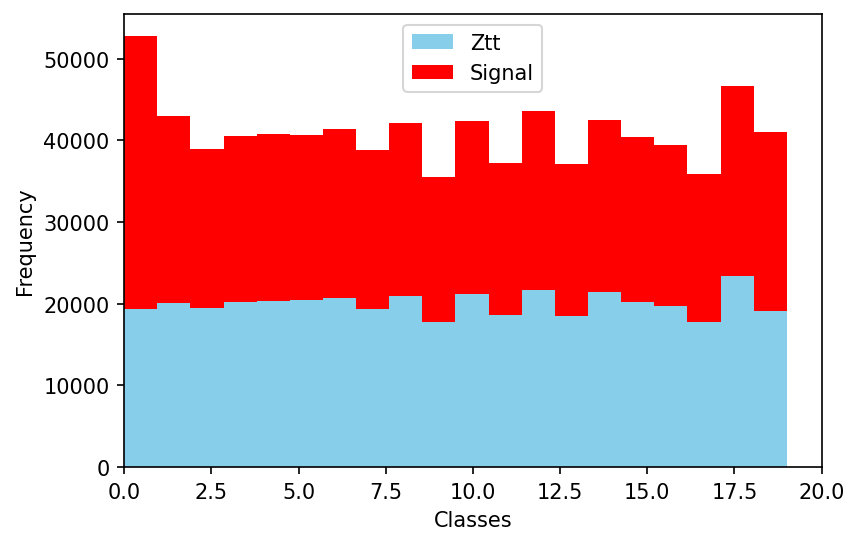

In [23]:
# create the dataframe; enumerate is used to make column names
columns=['Ztt','Signal']
fig,ax=plt.subplots(dpi=150)
plt.xlabel("Classes")
plt.ylabel("Events")
df = pd.concat([pd.DataFrame(a, columns=[columns[i]]) for i, a in enumerate([bg_outputs, np.argmax(signal_outputs,axis=1)], 0)], axis=1)

# plot the data
ax.set_xlim(0,args.NUM_CLASSES-1)
ax = df.plot.hist(stacked=True, bins=args.NUM_CLASSES-1,ax=ax, color = ['skyblue','red']).get_figure()
# ax.set_xticks(np.arange(args.NUM_CLASSES-1))

In [24]:
ax.savefig('TestResults_with_blackground_naive.pdf')

In [25]:
signal_df = pd.DataFrame(np.argmax(signal_outputs, axis=1), columns=[columns[1]])
bkgd_df = pd.DataFrame(bg_outputs, columns=[columns[0]])
signal_df = signal_df.groupby('Signal').size().to_frame('SgCounts').reset_index().rename({'Signal':'Class'},axis=1)
bkgd_df = bkgd_df.groupby('Ztt').size().to_frame('BgCounts').reset_index().rename({'Ztt':'Class'},axis=1)
total = pd.concat([signal_df,bkgd_df['BgCounts']],axis = 1)

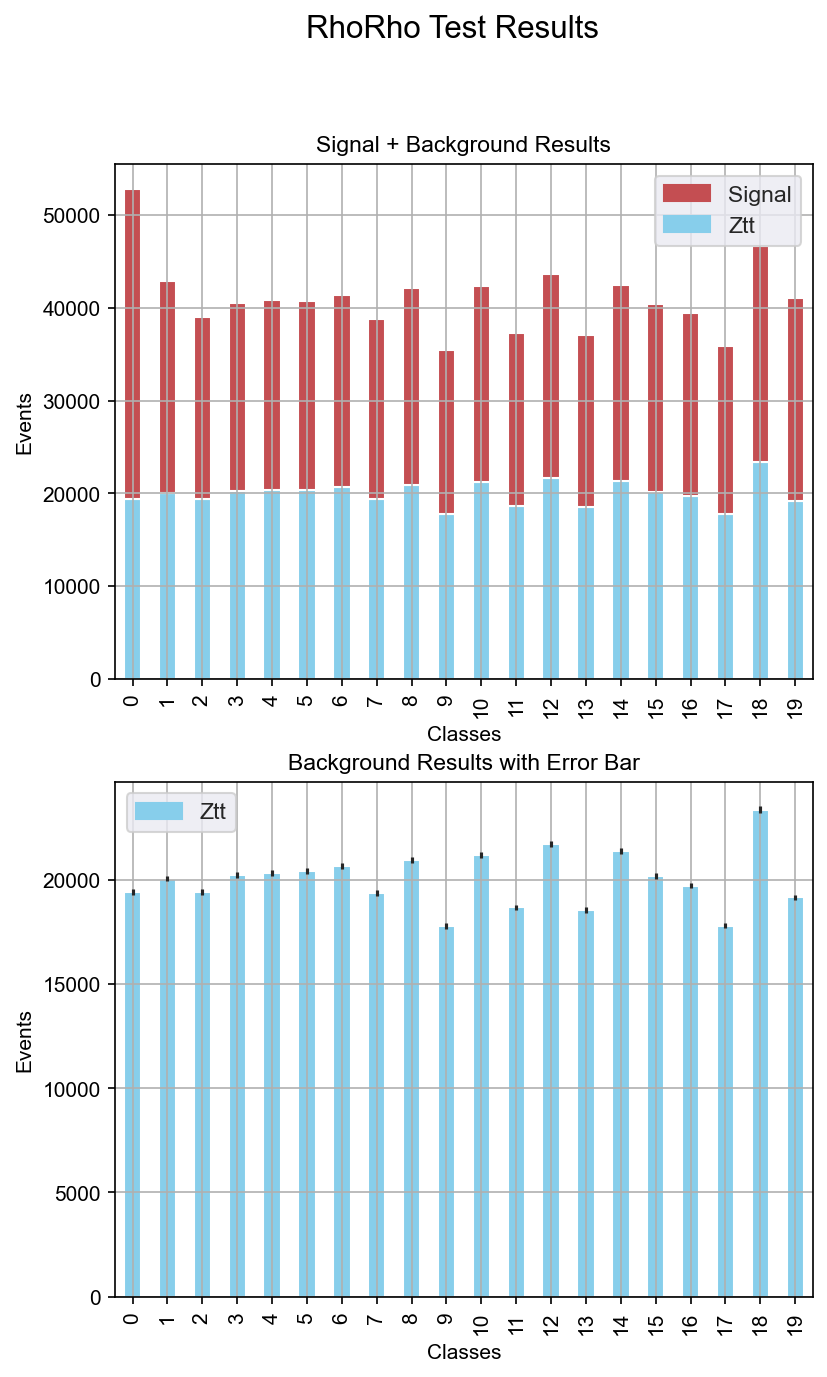

In [26]:
import seaborn as sns
import matplotlib.patches as mpatches

fig, axis = plt.subplots(2,1,figsize=(6,10),dpi=150)
fig.suptitle("RhoRho Test Results", fontsize=15)
axis[0].set_title('Signal + Background Results', fontsize=11)
axis[1].set_title('Background Results with Error Bar', fontsize=11)
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

total[['BgCounts','SgCounts']].plot(kind="bar", ax = axis[0],stacked=True,color = ['skyblue','r']).get_figure()

# add legend
top_bar = mpatches.Patch(color='r', label='Signal')
bottom_bar = mpatches.Patch(color='skyblue', label='Ztt')
axis[0].legend(handles=[top_bar, bottom_bar])

for i in range(len(axis)): 
    axis[i].set_xlabel("Classes",fontsize=10)
    axis[i].set_ylabel("Events",fontsize=10)


Poisson_std = [math.sqrt(i) for i in total['BgCounts'].to_numpy()]
total[['BgCounts']].plot(kind="bar", ax = axis[1],stacked=True,color = ['skyblue','r'], yerr = Poisson_std, alpha = 1)
# ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
axis[1].legend(handles=[bottom_bar])

# show the graph
plt.show()

In [27]:
fig.savefig('TestResults2_with_blackground_naive.pdf')

In [28]:
print(total)

    Class  SgCounts  BgCounts
0       0     33414     19418
1       1     22874     20064
2       2     19580     19428
3       3     20300     20233
4       4     20487     20328
5       5     20281     20405
6       6     20709     20654
7       7     19458     19384
8       8     21153     20937
9       9     17681     17789
10     10     21132     21196
11     11     18564     18674
12     12     21932     21712
13     13     18532     18547
14     14     21093     21380
15     15     20207     20180
16     16     19747     19728
17     17     18120     17805
18     18     23276     23368
19     19     21868     19154


In [29]:
print(signal_df)

    Class  SgCounts
0       0     33414
1       1     22874
2       2     19580
3       3     20300
4       4     20487
5       5     20281
6       6     20709
7       7     19458
8       8     21153
9       9     17681
10     10     21132
11     11     18564
12     12     21932
13     13     18532
14     14     21093
15     15     20207
16     16     19747
17     17     18120
18     18     23276
19     19     21868


In [30]:
print(bkgd_df)

    Class  BgCounts
0       0     19418
1       1     20064
2       2     19428
3       3     20233
4       4     20328
5       5     20405
6       6     20654
7       7     19384
8       8     20937
9       9     17789
10     10     21196
11     11     18674
12     12     21712
13     13     18547
14     14     21380
15     15     20180
16     16     19728
17     17     17805
18     18     23368
19     19     19154
